In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[50]:


from ipywidgets import VBox,HBox,Layout
import ipywidgets as widgets
import jupyros as jr
import tf
from tf.transformations import quaternion_matrix
import rospy
from IPython.display import display, clear_output
import time
import numpy as np
from nav_msgs.msg import Odometry
from geometry_msgs.msg import  Twist
from assignment_2_2023.msg import PlanningAction, PlanningGoal
from assignment_2_2023.msg import  PlanningActionResult, PlanningActionGoal,PlanningActionFeedback
from geometry_msgs.msg import PoseStamped
get_ipython().run_line_magic('matplotlib', 'notebook')
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import actionlib
  

In [2]:
rospy.init_node('NodeA', anonymous=True)



client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)

In [3]:

x_goal=widgets.BoundedFloatText(value=0.0,min=-10.0,max=10.0, step=0.1,layout=widgets.Layout(width='200px'), description='X_position:',disabled=False)
y_goal=widgets.BoundedFloatText(value=0.0,min=-10.0,max=10.0, step=0.1,layout=widgets.Layout(width='200px'), description='Y_position:',disabled=False)

button1_goal = widgets.Button(description="Send Goal", button_style='' 'info' '')
button2_cancel=widgets.Button(description="Cancel target",button_style='' 'danger' '')

In [4]:
goal_box = widgets.VBox([
    
    widgets.HBox([x_goal]),
    widgets.HBox([y_goal]),
    widgets.HBox([button1_goal, button2_cancel])
])


# In[54]:


disp = widgets.Textarea(value='', description='Goal Status')


In [5]:

def button1_Goal_callback(b):
    
    client.wait_for_server() 
    
    goal = PoseStamped()    
    goal.pose.position.x = x_goal.value
    goal.pose.position.y = y_goal.value
    #setting the goal, using the desired x,y of the user.
    goal = PlanningGoal(goal) 
    #sending the goal       
    client.send_goal(goal)
    status_goal = True
    goal_text = 'Your goal is set x= ({}, {})'.format(x_goal.value, y_goal.value)
    disp.value = goal_text       
            
            
def button2_cancel_callback(b):
    client.cancel_goal()
    calcel_text='Goal Cancelled'
    disp.value=calcel_text


    
button1_goal.on_click(button1_Goal_callback)
button2_cancel.on_click(button2_cancel_callback)
#display(out)


In [6]:
class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots(2, 1, figsize=(8, 10))
        self.robot_ln, = self.ax[1].plot([], [], 'o', label='Robot Position')
        self.target_ln, = self.ax[1].plot([], [], 'x', label='Target Position')

        goal = PoseStamped()
        self.x_robot = []
        self.y_robot = [] 
        self.x_target = []
        self.y_target = []

        self.x = ["Cancelled", "Reached"]
        self.y = [0, 0]
        self.reached_bar = self.ax[0].bar(self.x, self.y, color=['red', 'green'], edgecolor='black', linewidth=1, width=0.5)

    def plot_init(self):
        self.ax[1].set_xlim(-10, 10)
        self.ax[1].set_ylim(-10, 10)
        self.ax[1].set_title('Robot and Target Position')
        self.ax[1].set_xlabel('x_pos')
        self.ax[1].set_ylabel('y_pos')
        self.ax[1].legend()

        self.ax[0].set_xlim(0, 2)
        self.ax[0].set_ylim(0, 5)
        self.ax[0].set_title('Target Status Count')
        self.ax[0].set_xlabel('Status')
        self.ax[0].set_ylabel('')

        self.fig.subplots_adjust(hspace=0.5)

        return self.robot_ln, self.target_ln, self.reached_bar

    def odom_callback(self, msg):
        self.y_robot.append(msg.pose.pose.position.y)
        self.x_robot.append(msg.pose.pose.position.x)
    
    def TargetPoseCallback(self, goal: PlanningActionGoal):
        self.x_target = goal.goal.target_pose.pose.position.x
        self.y_target = goal.goal.target_pose.pose.position.y
        self.x_robot = []
        self.y_robot = []

    def GoalStatusCallback(self, msg: PlanningActionResult):
        self.state = msg.status.status
        if self.state == 2:
            self.y[0] += 1
        elif self.state == 3:
            self.y[1] += 1
        
        # Update the bar chart
        for bar, count in zip(self.reached_bar, self.y):
            bar.set_height(count)

    def update_plot(self, frame):
        self.ax[1].collections.clear()  # Clear any previous scatter plot
        self.robot_ln.set_data(self.x_robot, self.y_robot)
        self.target_ln.set_data(self.x_target, self.y_target)
        self.ax[0].set_xlim(-0.5, len(self.x) - 0.5)
        return self.robot_ln, self.target_ln, self.reached_bar


<IPython.core.display.Javascript object>


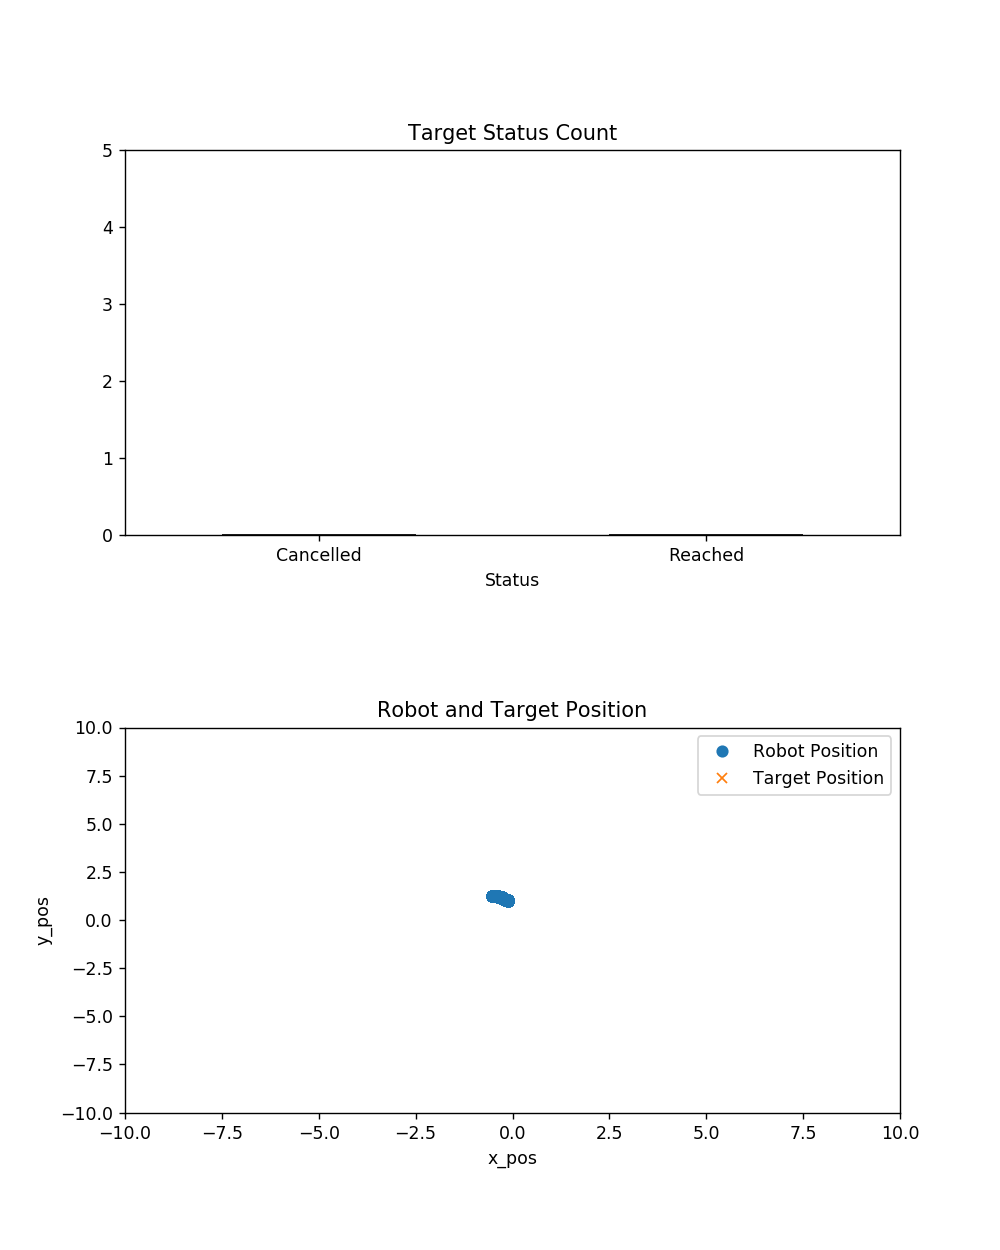

In [7]:
vis = Visualiser()

sub_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
target_sub = rospy.Subscriber('/reaching_goal/goal', PlanningActionGoal, vis.TargetPoseCallback)
subscriber = rospy.Subscriber('/reaching_goal/result', PlanningActionResult, vis.GoalStatusCallback)
display(goal_box)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init, blit=True, interval=200)
plt.show(block=True)
